In [28]:
import os
%matplotlib inline
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch import autograd
from torchvision.utils import save_image
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

# 设备配置
torch.cuda.set_device(0) # 这句话用来设置pytorch在哪块GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 定义一些超参数
num_epochs = 50
batch_size = 100
sample_dir = 'cgan_samples'

# 在当前目录，创建不存在的目录gan_samples
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    
# Image processing
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='data',
                                  train=True,
                                  transform=trans,
                                  download=False)

# Data loaders
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                         batch_size=batch_size,
                                         shuffle=True)

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10,10)
        
        self.model = nn.Sequential(
            nn.Linear(794,1024),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    
    def forward(self,x,labels):
        x = x.view(x.size(0),784)
        c = self.label_emb(labels)
        x = torch.cat([x,c],1)
        out = self.model(x)
        return out.squeeze()

In [30]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10,10)
        
        self.model = nn.Sequential(
            nn.Linear(110,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024,784),
            nn.Tanh()
        )
        
    def forward(self,z,labels):
        z = z.view(z.size(0),100)
        c = self.label_emb(labels)
        x = torch.cat([z,c],1)
        out = self.model(x)
        return out.view(x.size(0),28,28)

In [31]:
# 设备配置
torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU上
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator().to(device)
D = Discriminator().to(device)

# 定义判别器的损失函数交叉熵及优化器
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0001)
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0001)

#Clamp函数x限制在区间[min,max]内
def denorm(x):
    out = (x + 1) /2
    return out.clamp(0,1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# 开始训练
total_step = len(data_loader)

In [32]:
writer = SummaryWriter(log_dir='logs')

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        step = epoch * len(data_loader) + i + 1
        images = images.to(device)
        labels = labels.to(device)
        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.randint(0,10,(batch_size,)).to(device)
        # ================================================================== #
        #                      训练判别器                                    #
        # ================================================================== #

        # 定义判断器对真图片的损失函数
        real_validity  = D(images,labels)
        d_loss_real = criterion(real_validity,real_labels)
        real_score = real_validity
        # 定义判别器对假图片（即由潜在空间点生成的图片）的损失函数
        z = torch.randn(batch_size,100).to(device)
        fake_labels = torch.randint(0,10,(batch_size,)).to(device)
        fake_images = G(z,fake_labels)
        fake_validity = D(fake_images, fake_labels)
        d_loss_fake = criterion(fake_validity,torch.zeros(batch_size).to(device))
        fake_score = fake_images
        d_loss = d_loss_real + d_loss_fake

        # 对生成器、判别器的梯度清零
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        训练生成器                                  #
        # ================================================================== #

        #定义生成器对假图片的损失函数，这里我们要求
        #判别器生成的图片越来越像真图片，故损失函数中
        #的标签改为真图片标签，即希望生成的假图片，
        #越来越像靠近真图片

        z = torch.randn(batch_size, 100).to(device)
        fake_images = G(z, fake_labels)
        validity = D(fake_images, fake_labels)
        g_loss = criterion(validity, torch.ones(batch_size).to(device))

        # 对生成器、判别器的梯度清零
        # 进行反向传播及运行生成器的优化器
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        writer.add_scalars('scalars', {'g_loss':g_loss,'d_loss':d_loss}, step)

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step[{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)):{:.2f}'
                 .format(epoch, num_epochs, i+1, total_step, d_loss.item(),g_loss.item(),
                        real_score.mean().item(),fake_score.mean().item()*(-1)))
    # 保存真图片
    if (epoch+1) == 1:
        images = images.reshape(images.size(0),1,28,28)
        save_image(denorm(images),os.path.join(sample_dir, 'real_images.png'))
        
    
    fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
    save_image(denorm(fake_images),os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/50], Step[200/600], d_loss: 0.5215, g_loss: 1.6687, D(x): 0.92, D(G(z)):0.20
Epoch [0/50], Step[400/600], d_loss: 0.4498, g_loss: 2.4769, D(x): 0.83, D(G(z)):0.75
Epoch [0/50], Step[600/600], d_loss: 0.5574, g_loss: 2.5501, D(x): 0.72, D(G(z)):0.57
Epoch [1/50], Step[200/600], d_loss: 1.9617, g_loss: 0.5184, D(x): 0.55, D(G(z)):0.64
Epoch [1/50], Step[400/600], d_loss: 1.1210, g_loss: 2.2541, D(x): 0.58, D(G(z)):0.68
Epoch [1/50], Step[600/600], d_loss: 1.0526, g_loss: 1.5778, D(x): 0.56, D(G(z)):0.78
Epoch [2/50], Step[200/600], d_loss: 0.3341, g_loss: 2.9844, D(x): 0.90, D(G(z)):0.60
Epoch [2/50], Step[400/600], d_loss: 0.5220, g_loss: 2.4162, D(x): 0.85, D(G(z)):0.64
Epoch [2/50], Step[600/600], d_loss: 0.2681, g_loss: 2.7320, D(x): 0.95, D(G(z)):0.71
Epoch [3/50], Step[200/600], d_loss: 0.2408, g_loss: 3.9807, D(x): 0.92, D(G(z)):0.73
Epoch [3/50], Step[400/600], d_loss: 0.4336, g_loss: 4.1803, D(x): 0.90, D(G(z)):0.62
Epoch [3/50], Step[600/600], d_loss: 0.2327, g_loss: 4

Epoch [31/50], Step[600/600], d_loss: 0.9665, g_loss: 1.2670, D(x): 0.71, D(G(z)):0.72
Epoch [32/50], Step[200/600], d_loss: 0.9306, g_loss: 1.3393, D(x): 0.69, D(G(z)):0.76
Epoch [32/50], Step[400/600], d_loss: 0.8780, g_loss: 1.6111, D(x): 0.69, D(G(z)):0.73
Epoch [32/50], Step[600/600], d_loss: 0.8975, g_loss: 1.6464, D(x): 0.69, D(G(z)):0.74
Epoch [33/50], Step[200/600], d_loss: 1.0464, g_loss: 1.2382, D(x): 0.69, D(G(z)):0.74
Epoch [33/50], Step[400/600], d_loss: 0.8452, g_loss: 1.6281, D(x): 0.74, D(G(z)):0.72
Epoch [33/50], Step[600/600], d_loss: 0.8810, g_loss: 1.7241, D(x): 0.70, D(G(z)):0.71
Epoch [34/50], Step[200/600], d_loss: 1.0060, g_loss: 1.5114, D(x): 0.68, D(G(z)):0.73
Epoch [34/50], Step[400/600], d_loss: 1.0049, g_loss: 1.4253, D(x): 0.66, D(G(z)):0.73
Epoch [34/50], Step[600/600], d_loss: 0.9143, g_loss: 1.3974, D(x): 0.73, D(G(z)):0.76
Epoch [35/50], Step[200/600], d_loss: 1.1305, g_loss: 1.3163, D(x): 0.62, D(G(z)):0.71
Epoch [35/50], Step[400/600], d_loss: 1.116

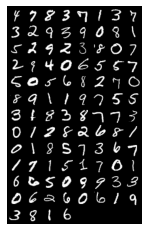

In [33]:
import matplotlib.pyplot as plt #plt 用于显示图片
import matplotlib.image as mpimg #mpimg 用于读取图片

reconsPath = './cgan_samples/real_images.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) #显示图片
plt.axis('off')#不显示坐标轴
plt.show()

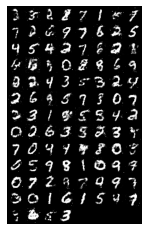

In [35]:
reconsPath = './cgan_samples/fake_images-50.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image)# 显示图片
plt.axis('off') #不显示坐标轴
plt.show()

(-0.5, 301.5, 301.5, -0.5)

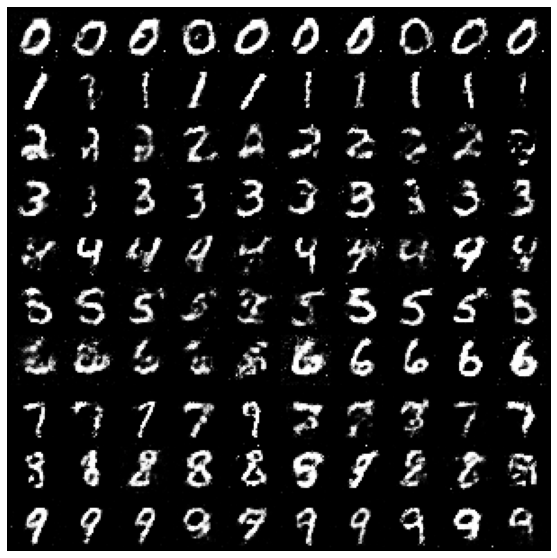

In [37]:
from torchvision.utils import make_grid
z = torch.randn(100,100).to(device)
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(device)

images = G(z,labels).unsqueeze(1)
grid = make_grid(images, nrow=10, normalize=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).detach().cpu().numpy(), cmap='binary')
ax.axis('off')